# Insect Pest Species Classification

In [ ]:
!pwd

## Downloading the dataset

In [2]:
# !bash script/download_dataset.sh

## Dataloader

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from tqdm import tqdm

class InsectDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = self._read_annotations(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def _read_annotations(self, annotations_file):
        with open(annotations_file, 'r') as f:
            lines = f.readlines()   # (image_name, label) (00403.jpg 0)
        
        return [line.strip().split() for line in lines]
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels[idx][0]))
        image = Image.open(img_path)
        # make sure all the image have the same channel
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = int(self.img_labels[idx][1])
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

#  Create datasets
train_dataset = InsectDataset(annotations_file='./dataset/ip102_v1.1/train.txt', img_dir='./dataset/ip102_v1.1/images', transform=transform)
val_dataset = InsectDataset(annotations_file='./dataset/ip102_v1.1/val.txt', img_dir='./dataset/ip102_v1.1/images', transform=transform)
test_dataset = InsectDataset(annotations_file='./dataset/ip102_v1.1/test.txt', img_dir='./dataset/ip102_v1.1/images', transform=transform)

In [5]:
# Create dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 45095
Validation dataset size: 7508
Test dataset size: 22619


# Define Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(in_features=32*56*56, out_features=102)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# add dropout to enhance the model

# Hyperparameters

In [8]:
learning_rate = 0.001
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

# Utilize Pretrained Model

check the [torchvision.models](https://pytorch.org/vision/stable/models.html#classification) for more details.

- The paper uses: AlexNet, GoogleNet, VGGNet, RestNet
- Try uses: ConvNeXt, EfficentNet, Vision Transformer

In [ ]:
# # use pre-trained model
# import torchvision.models as models
# from torchvision.models import VGG16_Weights

# # Load the pre-trained model
# model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# # Replace the last fully connected layer
# num_features = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_features, 102)

# model = model.to(device)

# Optimizer and Loss Function

In [9]:
# adam optimizer and cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train

In [10]:
train_acc, train_loss = [], []
val_acc, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    running_acc, running_loss = 0.0, 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # move the data to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_acc += (preds == targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    model.eval()
    running_acc, running_loss = 0.0, 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
        data = data.to(device=device)
        targets = targets.to(device=device)

        with torch.no_grad():
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_acc += (preds == targets).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_acc / len(val_loader)
    val_acc.append(epoch_acc)
    val_loss.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc:.4f}")

100%|██████████| 705/705 [02:19<00:00,  5.06it/s]


Epoch 1/5, Train Loss: 3.9570, Train Accuracy: 8.2000


100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Epoch 1/5, Validation Loss: 3.6771, Validation Accuracy: 10.4661


100%|██████████| 705/705 [01:39<00:00,  7.08it/s]


Epoch 2/5, Train Loss: 3.2718, Train Accuracy: 14.9603


100%|██████████| 118/118 [00:16<00:00,  7.21it/s]


Epoch 2/5, Validation Loss: 3.5482, Validation Accuracy: 13.5678


100%|██████████| 705/705 [01:42<00:00,  6.88it/s]


Epoch 3/5, Train Loss: 2.2395, Train Accuracy: 28.5589


100%|██████████| 118/118 [00:16<00:00,  7.25it/s]


Epoch 3/5, Validation Loss: 3.9731, Validation Accuracy: 15.3475


100%|██████████| 705/705 [01:41<00:00,  6.95it/s]


Epoch 4/5, Train Loss: 1.2013, Train Accuracy: 44.0865


100%|██████████| 118/118 [00:16<00:00,  7.23it/s]


Epoch 4/5, Validation Loss: 5.1826, Validation Accuracy: 15.9153


100%|██████████| 705/705 [01:41<00:00,  6.96it/s]


Epoch 5/5, Train Loss: 0.6159, Train Accuracy: 53.9177


100%|██████████| 118/118 [00:16<00:00,  7.19it/s]

Epoch 5/5, Validation Loss: 6.8851, Validation Accuracy: 15.5424


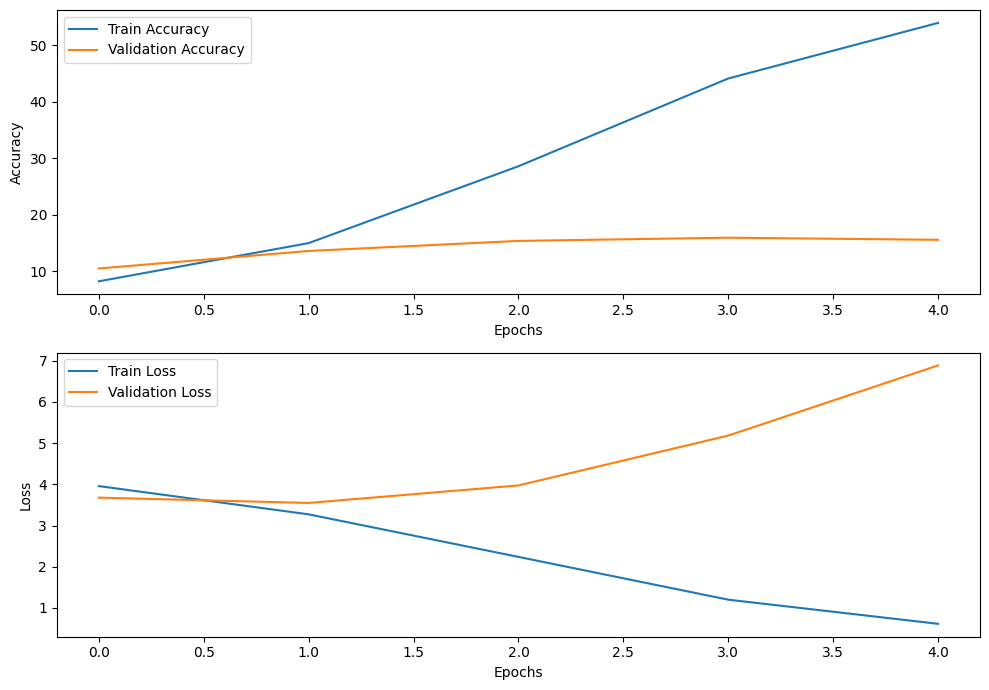

In [11]:
# plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test

In [ ]:
# test the model

model.eval()
running_acc = 0.0
running_loss = 0.0
for batch_idx, (data, targets) in enumerate(tqdm(test_loader)):
    data = data.to(device=device)
    targets = targets.to(device=device)

    with torch.no_grad():
        outputs = model(data)
        loss = criterion(outputs, targets)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_acc += (preds == targets).sum().item()

test_loss = running_loss / len(test_loader)
test_acc = running_acc / len(test_loader)

# Save model

In [ ]:
# save model
torch.save(model.state_dict(), 'insect_classification.pth')

# Load model

In [ ]:
# load model
# model = CNN().to(device)
# model.load_state_dict(torch.load('insect_classification.pth'))